In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import all VGG16 classes
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Model

# construct an instance of the ImageDataGenerator class
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    horizontal_flip = True,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2)

test_datagen = ImageDataGenerator(
    rescale = 1./255)

'''model = keras.Sequential()
model = VGG16(include_top=False)

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))'''


#To the basic loaded model, we are changing only the final prediction layer.
#include_top set to false will not load the last fully-connected output layers
#after last max pooling layer, we will manually add a Flatten layer and rest
#if include_top is false we need to specify the input shape 

model = VGG16(include_top=False, input_shape = (224, 224, 3))

# specify the layers loaded as not trainable
for layer in model.layers:
    layer.trainable = False


# Flatten the output layer to 1 dimension before starting the fully connected layer
flatten_layer = layers.Flatten()(model.output)



# Add a fully connected layer with 512 hidden units and ReLU activation
flattened_fc_layer = layers.Dense(512, activation='relu')(flatten_layer )


# Add the last sigmoid layer for classification
flattened_fc_sigmoid_layer = layers.Dense(5, activation='softmax')(flattened_fc_layer)

# define new model with base model and new layers combined
model =  Model(inputs=model.inputs, outputs=flattened_fc_sigmoid_layer)

# summarize the model
model.summary()


# prepare iterators
training_iterator = train_datagen.flow_from_directory('dataset/flowers/train', batch_size=64, target_size=(224, 224))
# move around 240 images (30% of 800) from train to test for every flower
testing_iterator = test_datagen.flow_from_directory('dataset/flowers/test', batch_size=64, target_size=(224, 224))

# compile model
model.compile(loss = "categorical_crossentropy", metrics=['accuracy'], optimizer='adam')

# fit model
history = model.fit(training_iterator, validation_data=testing_iterator, epochs = 4 )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

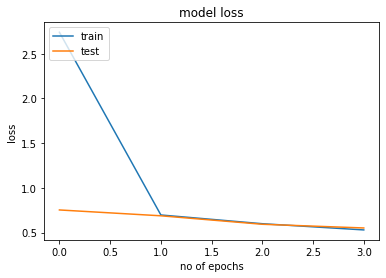

In [2]:
import matplotlib.pyplot as plt

#plot loss vs epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('no of epochs')
plt.legend(['train','test'],loc='upper left')
plt.show()

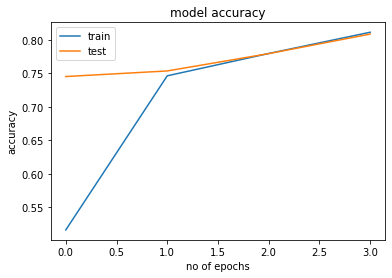

In [3]:
#plot accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('no of epochs')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [4]:
model.save('models/transfer_vgg16_flower.h5')

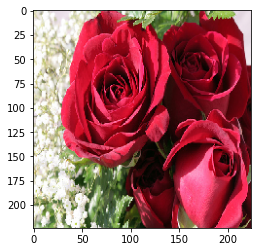

The prediction is :
rose


In [5]:






















from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# load model
model = load_model('models/transfer_vgg16_flower.h5')
                   
# load the image
img = load_img('dataset/flowers/train/rose/568715474_bdb64ccc32.jpg', target_size=(224, 224))
#img = load_img('dataset/flowers/train/tulip/133692329_c1150ed811_n.jpg', target_size=(224, 224))
#img = load_img('dataset/flowers/train/sunflower/44079668_34dfee3da1_n.jpg', target_size=(224, 224))

# show image inline
plt.imshow(img)
plt.show()

# prepare input
# convert to array
img = img_to_array(img)
# reshape into a single sample with 3 channels
img = img.reshape(1, 224, 224, 3)

# get prediction
result = model.predict(img)

# class lables from the iterator
class_labels = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

# To print a predicted label from testing_iterator.class_indices
print("The prediction is :")
print([key for key in class_labels][np.argmax(result)])
